# EXPLORATORY DATA ANALYSIS (I.)

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


In [3]:
predictors = [
    'L3',
    'L2',
    'L1',
    'CF_CL',
    'CASH_TA',
    'SAL_TA',
    'TL_SAL',
    'INV_COST',
    'INV_SAL',
    'CC_SAL',
    'TA_SAL',
    'TL_TA',
    'CF_TL',
    'CL_TA',
    'NCL_TA',
    'EQ_TL',
    'EQ_TA',
    'CL_CC',
    'ROE',
    'EAT_TA',
    'ROA_BRUTTO',
    'CF_TA',
    'CF_SAL',
    'ROS',
    'EAT_YIE',
    'ROI',
    'ROA_NETTO']

print(len(predictors))

27


## Data preparation

In [4]:
financial_ratios_table_raw = pd.read_csv('../../DATA/MODEL/FINAL_financial_ratios_df.csv')
display(financial_ratios_table_raw.shape[0])
# financial_ratios_table_raw.query('year == 2018 or SAL_CLASS not in ["<50,000", ">150,000,000"]', inplace=True)
# display(financial_ratios_table_raw.shape[0])

704928

In [5]:
INDICATORS = ['RUZ_cancelled_2y_off', 'RU_konkurz_2y_off', 'RU_ostatne_konania_2y_off', 'DPHZ_vat_registration_cancelled_2y_off', 'RUZ_indirect_criterion_2y_off']


def get_direct_indicator_2y_off(x):
    if x.RUZ_cancelled_2y_off == 1 or x.RU_konkurz_2y_off == 1 or x.RU_ostatne_konania_2y_off == 1 or x.DPHZ_vat_registration_cancelled_2y_off == 1:
        return 1
    return 0

def get_direct_indicator_1y_off(x):
    if x.RUZ_cancelled_1y_off == 1 or x.RU_konkurz_1y_off == 1 or x.RU_ostatne_konania_1y_off == 1 or x.DPHZ_vat_registration_cancelled_1y_off == 1:
        return 1
    return 0

def get_pair_indicator_2y_off(x):
    if x.direct_indicator_2y_off == 1 and x.RUZ_indirect_criterion_2y_off == 1: return 1
    if x.direct_indicator_2y_off == 1: return 0.5
    return 0


def get_pair_indicator_1y_off(x):
    if x.direct_indicator_1y_off == 1 and x.RUZ_indirect_criterion_1y_off == 1: return 1
    if x.direct_indicator_1y_off == 1: return 0.5
    return 0

financial_ratios_table_raw['direct_indicator_2y_off'] = financial_ratios_table_raw.apply(get_direct_indicator_2y_off, axis = 1)
financial_ratios_table_raw['pair_indicator_2y_off'] = financial_ratios_table_raw.apply(get_pair_indicator_2y_off, axis = 1)
financial_ratios_table_raw['direct_indicator_1y_off'] = financial_ratios_table_raw.apply(get_direct_indicator_1y_off, axis = 1)
financial_ratios_table_raw['pair_indicator_1y_off'] = financial_ratios_table_raw.apply(get_pair_indicator_1y_off, axis = 1)

In [6]:
YEARS = sorted(financial_ratios_table_raw['year'].unique())
YEARS

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

In [7]:
master_set_2017 = set(financial_ratios_table_raw['entity_ico'].unique())

for year in 2015, 2016, 2017:
    subset = financial_ratios_table_raw.query('year == @year and RUZ_indirect_criterion == 0 and RUZ_cancelled == 0 and RU_konkurz == 0 and RU_ostatne_konania == 0 and DPHZ_vat_registration_cancelled == 0')
    subset_set = set(subset['entity_ico'].unique())

    master_set_2017 = master_set_2017.intersection(subset_set)


display(len(master_set_2017))


master_set_2018 = set(financial_ratios_table_raw['entity_ico'].unique())

for year in 2016, 2017, 2018:
    subset = financial_ratios_table_raw.query('year == @year and RUZ_indirect_criterion == 0 and RUZ_cancelled == 0 and RU_konkurz == 0 and RU_ostatne_konania == 0 and DPHZ_vat_registration_cancelled == 0')
    subset_set = set(subset['entity_ico'].unique())

    master_set_2018 = master_set_2018.intersection(subset_set)



display(len(master_set_2018))

31882

34913

In [8]:
# financial_ratios_table_raw = financial_ratios_table_raw.query('entity_ico in @master_set')
# financial_ratios_table_raw

In [9]:
SAL_CLASSES = sorted(financial_ratios_table_raw['sal_class'].unique())
SKNACE_GROUPS = financial_ratios_table_raw['sknace_division'].unique()

In [10]:
from sklearn.impute import SimpleImputer


def fill_missing_values_mean(data):
    # Instantiate SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the data and transform the data
    imputed_data = imputer.fit_transform(data)

    return imputed_data

financial_ratios_table_2017 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset = financial_ratios_table_raw.query('sal_class == @sal_class and sknace_division == @sknace and year == 2017 and entity_ico in @master_set_2017')
        if subset.shape[0] < 10:
            continue
        for col in predictors:
            col_mean = subset[col].mean()
            subset[col].fillna(col_mean)

        financial_ratios_table_2017 = pd.concat([financial_ratios_table_2017, subset], axis = 0)

display(financial_ratios_table_2017)




financial_ratios_table_2018 = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset = financial_ratios_table_raw.query('sal_class == @sal_class and sknace_division == @sknace and year == 2018 and entity_ico in @master_set_2018')
        if subset.shape[0] < 10:
            continue
        for col in predictors:
            col_mean = subset[col].mean()
            subset[col].fillna(col_mean)

        financial_ratios_table_2018 = pd.concat([financial_ratios_table_2018, subset], axis = 0)

display(financial_ratios_table_2018)

,financial_report_id,financial_statement_id,financial_report_order_number,entity_id,approved_date,entity_ico,year,month,financial_report_template_id,entity_name,...,RUZ_indirect_criterion_2y_off,sknace_division_name,sknace_division,sknace_subcategory,sal_class,is_outlier,direct_indicator_2y_off,pair_indicator_2y_off,direct_indicator_1y_off,pair_indicator_1y_off
19,6044719,3494886,1,184,2018-06-28,2313.0,2017,1,699.0,HPK engineering a.s.,...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
446,6117750,3556296,1,10087,2018-03-23,590380.0,2017,1,699.0,"I N P R O , spol. s. r.o.",...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
509,5976862,3434402,1,19184,2018-02-16,594342.0,2017,1,699.0,"ARKA- architektonická kancelária, spoločnosť s...",...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
834,5988100,3444376,1,27303,2017-02-27,611808.0,2017,1,687.0,"CSA & EBO, spol.s.r.o.",...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
966,6224273,3647856,2,13027,2018-10-26,614556.0,2017,1,699.0,"BDR, spol. s r.o.",...,0.0,Právne a účtovnícke činnosti,M,69.0,1. Mikro,False,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202385,6133640,3570968,1,67286,2018-06-28,36500968.0,2017,1,699.0,Podtatranská vodárenská prevádzková spoločnosť...,...,1.0,"Zber, úprava a dodávka vody",E,36.0,3. Stredný,False,0,0.0,0,0.0
214199,6176509,3607804,3,566740,2018-08-24,36547301.0,2017,1,699.0,"General Plastic, a. s.",...,0.0,"Zber, spracúvanie a likvidácia odpadov; recykl...",E,38.0,3. Stredný,False,0,0.0,0,0.0
246062,6123041,3561253,1,527629,2018-04-30,36672076.0,2017,1,699.0,"Považská vodárenská spoločnosť, a.s.",...,0.0,"Zber, úprava a dodávka vody",E,36.0,3. Stredný,False,0,0.0,0,0.0
246139,6126247,3564222,1,590461,2018-05-31,36672297.0,2017,1,699.0,"Severoslovenské vodárne a kanalizácie, a. s.",...,0.0,"Zber, úprava a dodávka vody",E,36.0,3. Stredný,False,0,0.0,0,0.0


,financial_report_id,financial_statement_id,financial_report_order_number,entity_id,approved_date,entity_ico,year,month,financial_report_template_id,entity_name,...,RUZ_indirect_criterion_2y_off,sknace_division_name,sknace_division,sknace_subcategory,sal_class,is_outlier,direct_indicator_2y_off,pair_indicator_2y_off,direct_indicator_1y_off,pair_indicator_1y_off
20,6538105,3894487,2,184,2019-06-11,2313.0,2018,1,699.0,HPK engineering a.s.,...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
306,6528970,3886500,1,18205,NaN,584851.0,2018,1,687.0,METRODAT s.r.o.,...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
447,6566828,3918340,1,10087,2018-12-31,590380.0,2018,1,699.0,"I N P R O , spol. s. r.o.",...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
510,6428613,3796263,1,19184,2019-02-08,594342.0,2018,1,699.0,"ARKA- architektonická kancelária, spoločnosť s...",...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
835,6429733,3797289,1,27303,2019-02-18,611808.0,2018,1,687.0,"CSA & EBO, spol.s.r.o.",...,0.0,Architektonické a inžinierske činnosti; techni...,M,71.0,1. Mikro,False,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214200,6598618,3944493,3,566740,2019-12-05,36547301.0,2018,1,699.0,"General Plastic, a. s.",...,0.0,"Zber, spracúvanie a likvidácia odpadov; recykl...",E,38.0,3. Stredný,False,0,0.0,0,0.0
242409,6603063,3948696,1,506953,2019-03-18,36656607.0,2018,1,699.0,"Remarkplast Slovakia, s.r.o.",...,0.0,"Zber, spracúvanie a likvidácia odpadov; recykl...",E,38.0,3. Stredný,False,0,0.0,0,0.0
246063,6580706,3929526,3,527629,2019-06-11,36672076.0,2018,1,699.0,"Považská vodárenská spoločnosť, a.s.",...,0.0,"Zber, úprava a dodávka vody",E,36.0,3. Stredný,False,0,0.0,0,0.0
246140,6624138,3967237,4,590461,2019-05-31,36672297.0,2018,1,699.0,"Severoslovenské vodárne a kanalizácie, a. s.",...,1.0,"Zber, úprava a dodávka vody",E,36.0,3. Stredný,False,0,0.0,0,0.0


In [11]:
group_column = 'sal_class'

display(
    pd.concat(
        [
            financial_ratios_table_2017.query('is_outlier == False')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('sample_size'),
            
            financial_ratios_table_2017.query('is_outlier == False and RUZ_indirect_criterion_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('indirect_indicator_count'),
            
            financial_ratios_table_2017.query('is_outlier == False and direct_indicator_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('direct_indicator_count'),
            
            financial_ratios_table_2017.query('is_outlier == False and pair_indicator_2y_off == 1')
            .groupby([group_column])
            ['financial_statement_id'].nunique()
            .to_frame('combined_indicator_count'),

        ], axis = 1
        ).reset_index())

,sal_class,sample_size,indirect_indicator_count,direct_indicator_count,combined_indicator_count
0,1. Mikro,27123,2886,132,29
1,2. Malý,3513,333,30,11
2,3. Stredný,1019,71,7,1


## Data distribution

In [12]:
# def plot_histograms(df, columns, filter_out_outliers = True):
#     # Plotting the histograms
#     fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
#     axes = axes.flatten()

#     for i, column in enumerate(columns):
#         ax = axes[i]


#         data = df.query(f'{column} == {column}')[column]
        
#         Q1 = data.quantile(0.25)
#         Q3 = data.quantile(0.75)
        
#         IQR = Q3 - Q1
        
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         if filter_out_outliers:
#             cleaned_data = data[~((data < lower_bound) | (data > upper_bound))]
#         else:
#             cleaned_data = data

#         bin_width = 2 * IQR / (len(cleaned_data) ** (1/3))

#         num_bins = int(np.ceil((np.max(cleaned_data) - np.min(cleaned_data)) / bin_width))

#         sns.histplot(cleaned_data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
#         # sns.kdeplot(cleaned_data, color='red', ax=ax, linewidth=2)  # Adding KDE plot
#         ax.set_title(column)
#         ax.set_xlabel('Value')
#         ax.set_ylabel('Frequency')

#     # Hide empty subplots
#     for j in range(len(columns), len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

In [13]:
# # plot_histograms(financial_ratios_table.query('year == 2018'), predictors)
# plot_histograms(financial_ratios_table.query('year == 2018 and is_outlier == 0'), predictors)

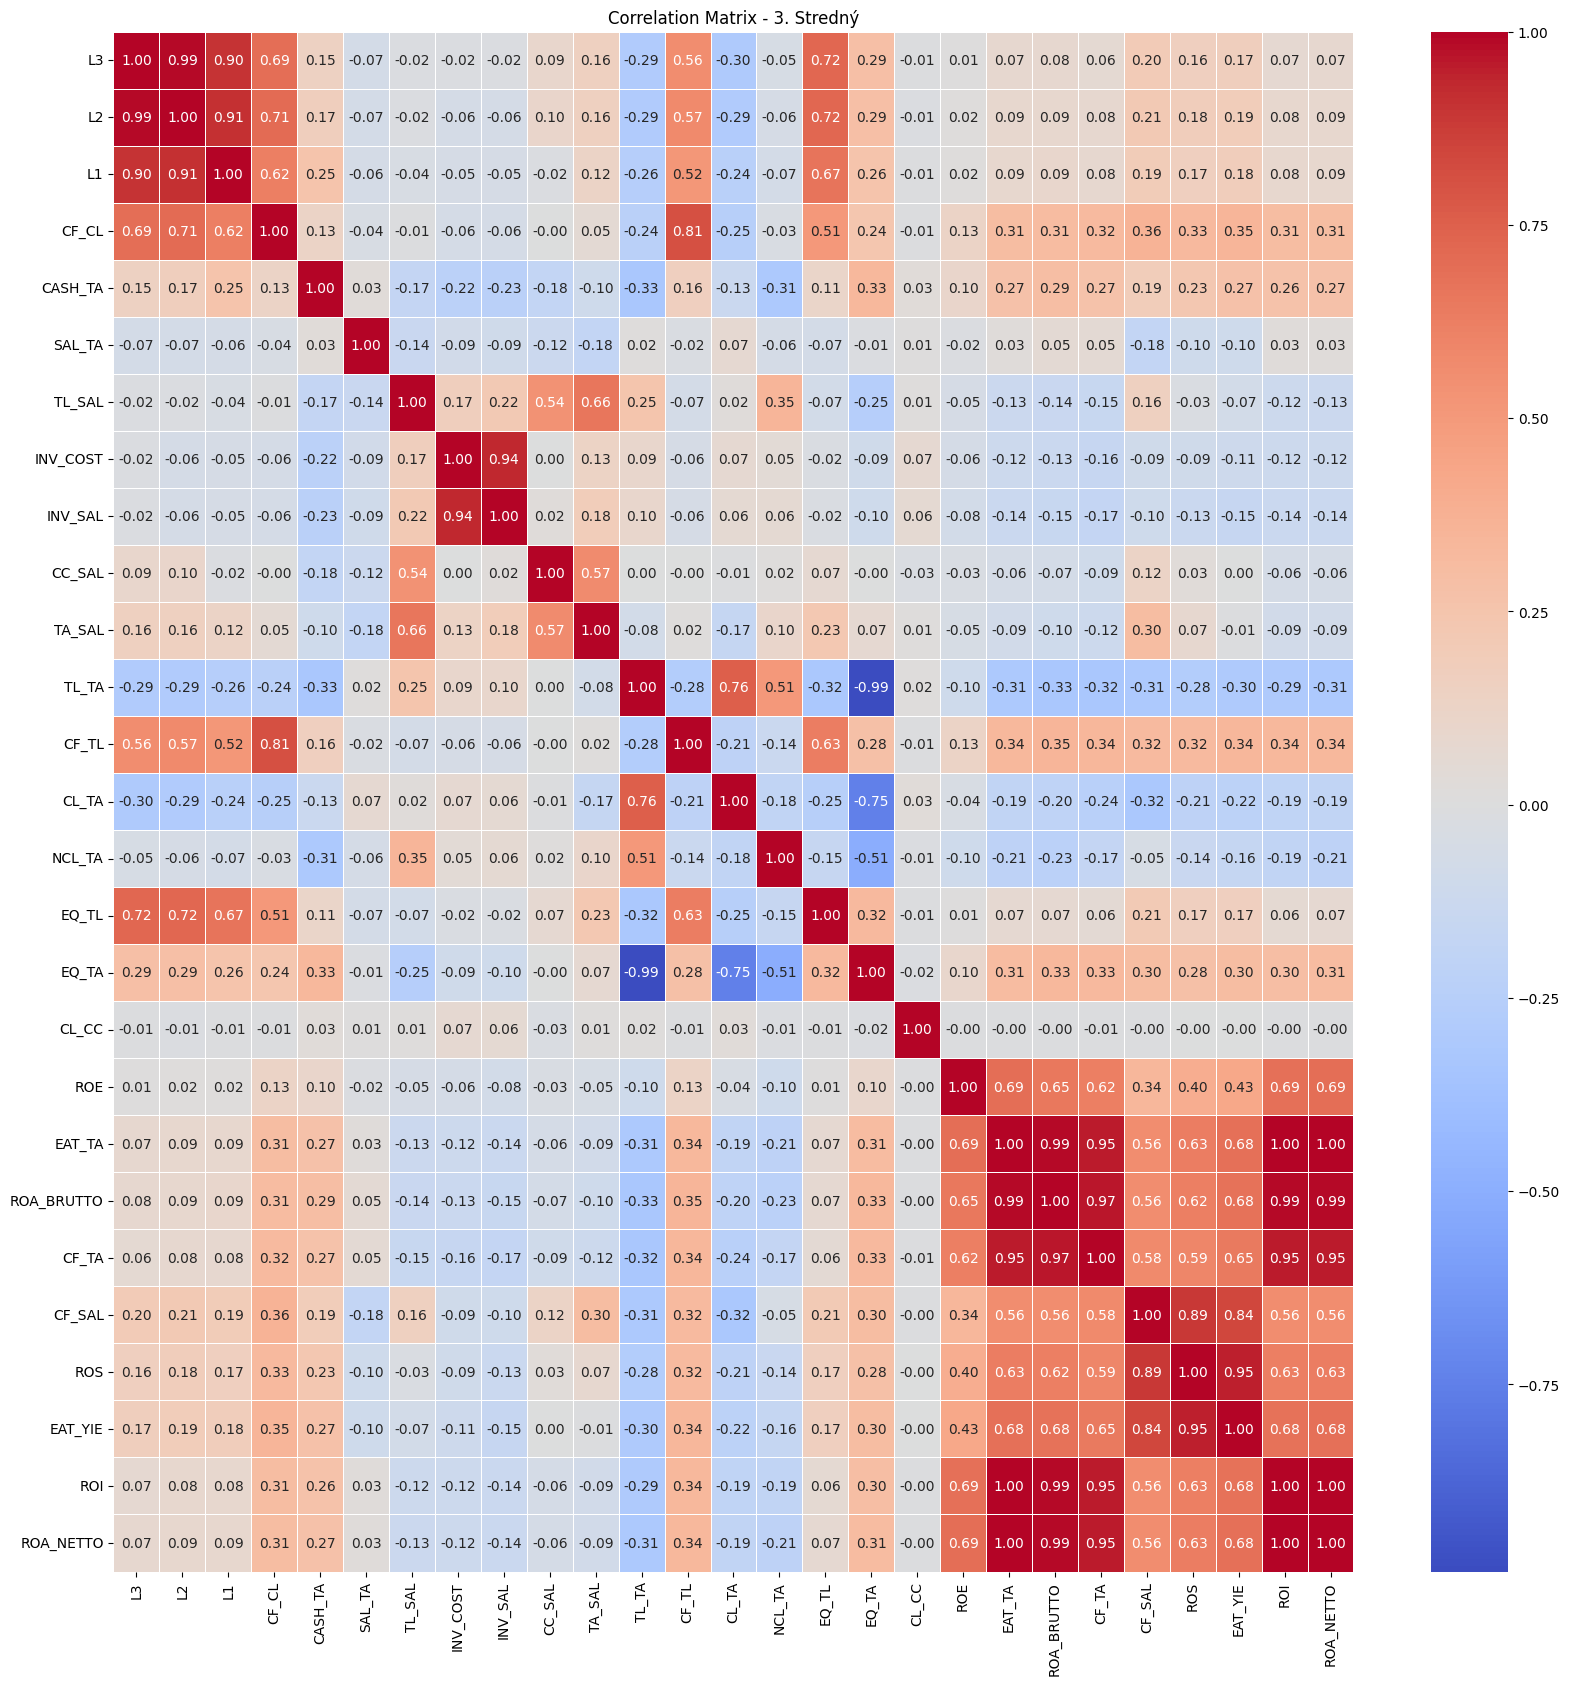

In [14]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[predictors].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix - {sal_class}')
plt.show()

In [15]:
import pandas as pd
import statsmodels.api as sm

def calculate_vif(data):
    # Add a constant term to the independent variables matrix
    X = sm.add_constant(data)

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: round(x, 2))

    return vif_data



vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(financial_ratios_table_2017[predictors]), columns=predictors))
display(vif_result)

vif_result = calculate_vif(pd.DataFrame(fill_missing_values_mean(financial_ratios_table_2017[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']]), columns=['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']))
display(vif_result)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_10784\2465775241.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  vif_data['VIF'] = [1 / (1 - sm.OLS(X[col], X.drop(columns=[col])).fit().rsquared) for col in X.columns]


,Feature,VIF
0,const,449.34
1,L3,8748.96
2,L2,9009.18
3,L1,182.88
4,CF_CL,29.57
5,CASH_TA,1.17
6,SAL_TA,6.21
7,TL_SAL,1.42
8,INV_COST,1.52
9,INV_SAL,1.59


,Feature,VIF
0,const,6.49
1,SAL_TA,1.04
2,ROE,1.90
3,ROA_NETTO,2.19
4,TL_TA,1.50
5,CASH_TA,1.12
6,ROS,1.01
7,NCL_TA,1.40
8,TL_SAL,1.04


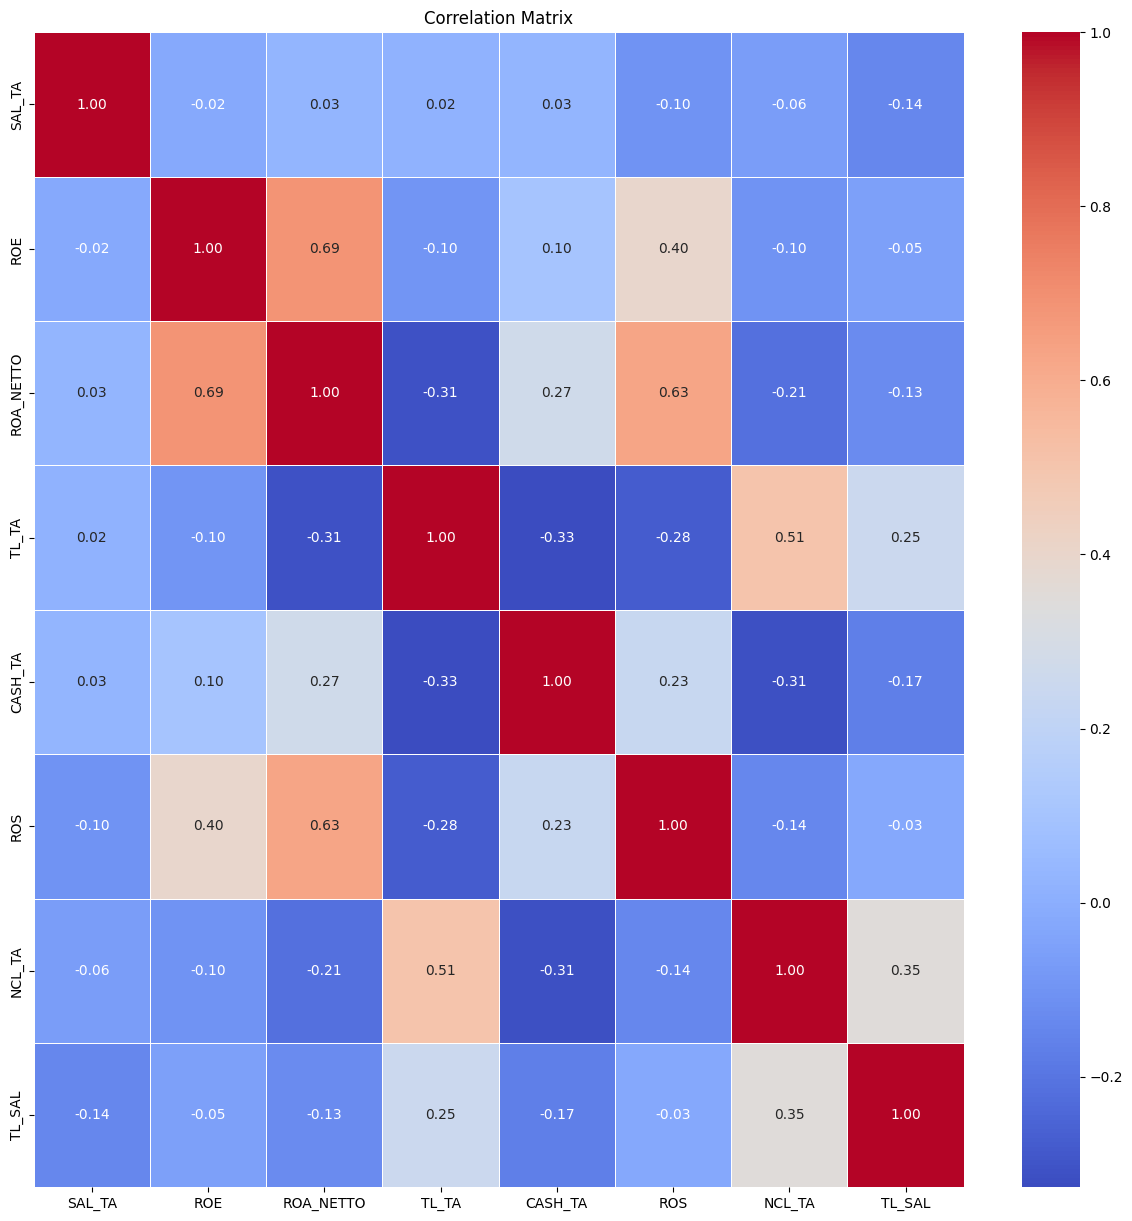

In [16]:
# Calculate the correlation matrix
correlation_matrix = financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix')
plt.show()

## Models

### Logistic Regression

Accuracy: 0.9598799557731796
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.48153724247226626
Balanced Accuracy: 0.48153724247226626


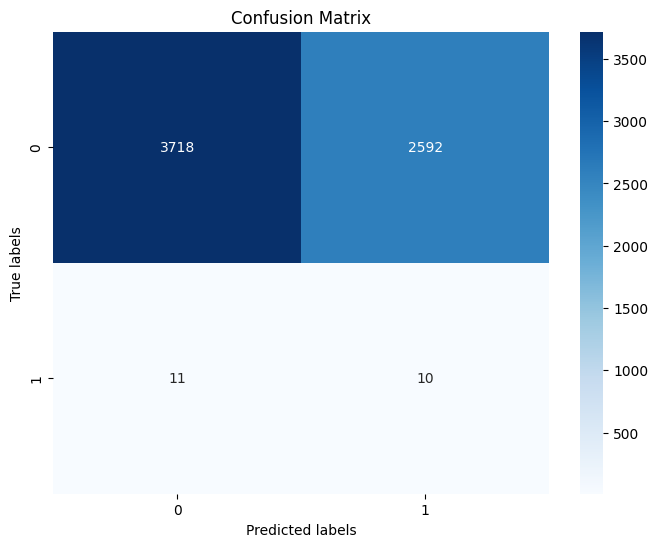

In [26]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Generating some sample data with imbalanced classes

X =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']].values)
y =  financial_ratios_table_2017.query('is_outlier == False')['direct_indicator_1y_off'].fillna(1).values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Creating logistic regression model
logistic_model = LogisticRegression()

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Logistic Regression', logistic_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree

Accuracy: 0.960511767493287
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.48185419968304277
Balanced Accuracy: 0.48185419968304277


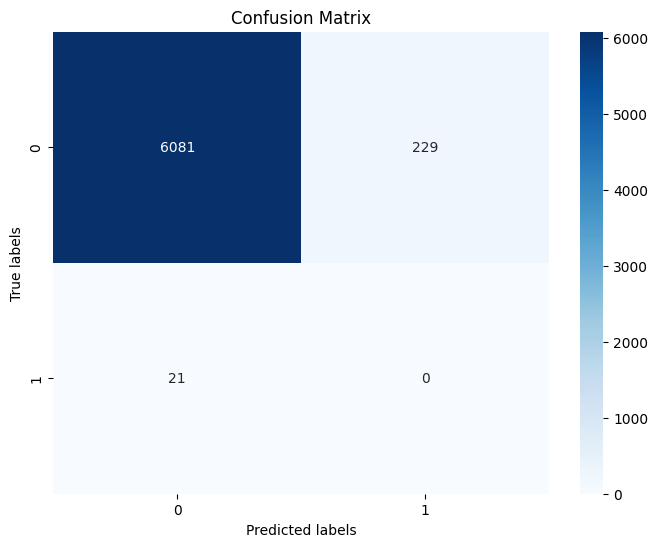

In [31]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Generating some sample data with imbalanced classes

X =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']].values)
y =  financial_ratios_table_2017.query('is_outlier == False')['direct_indicator_1y_off'].fillna(1).values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Creating Decision Tree classifier
tree_model = DecisionTreeClassifier(criterion="gini")

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('Decision Tree', tree_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Support Vector Machine

Accuracy: 0.6119096509240246
Precision: 0.20911127707244212
Recall: 0.6229143492769744
F1 Score: 0.3131115459882583
ROC AUC Score: 0.6165013572599894
Balanced Accuracy: 0.6165013572599894


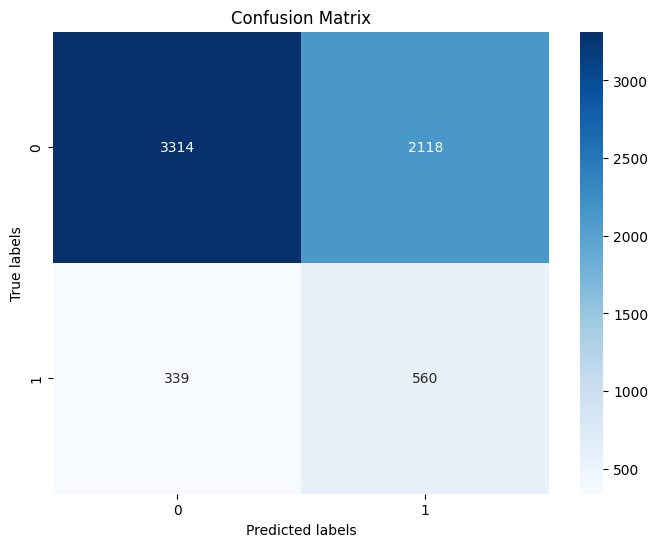

In [28]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Generating some sample data with imbalanced classes

X =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']].values)
y =  financial_ratios_table_2017.query('is_outlier == False')['RUZ_indirect_criterion_2y_off'].fillna(1).values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Creating SVM classifier
svm_model = SVC(kernel='linear')  # You can choose different kernels such as 'linear', 'rbf', 'poly', etc.

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus), ('SVM', svm_model)])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting on the testing set
y_pred = pipeline.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### Neural Net

Shape of X_train_resampled: (43460, 8)
198/198 [==============================] - 0s 786us/step
Accuracy: 0.6810930342757858
Precision: 0.24241030358785648
Recall: 0.5862068965517241
F1 Score: 0.3429873088187439
ROC AUC Score: 0.641501828246407
Balanced Accuracy: 0.6415018282464069


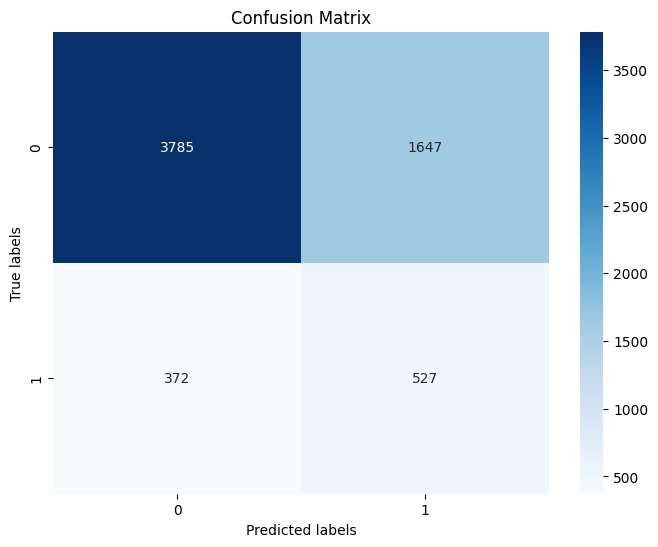

In [29]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense

# Generating some sample data with imbalanced classes

X =  fill_missing_values_mean(financial_ratios_table_2017.query('is_outlier == False')[['SAL_TA', 'ROE', 'ROA_NETTO', 'TL_TA', 'CASH_TA', 'ROS', 'NCL_TA', 'TL_SAL']].values)
y =  financial_ratios_table_2017.query('is_outlier == False')['RUZ_indirect_criterion_2y_off'].fillna(1).values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Reshape y_train to match the expected shape for Keras
y_train = y_train.reshape(-1, 1)


# Creating a neural network classifier
model = Sequential()
model.add(Dense(10, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a pipeline to combine sampling and modeling
pipeline = Pipeline([('SMOTE', smote), ('RUS', rus)])

# Fitting the pipeline on the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Check the shape of X_train_resampled
print("Shape of X_train_resampled:", X_train_resampled.shape)

# Creating a neural network classifier
model = Sequential()
# Adjust the input shape based on the actual number of features in X_train_resampled
model.add(Dense(10, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the neural network on the resampled data
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=10, verbose=0)

# Predicting on the testing set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# Print all evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Balanced Accuracy:", balanced_accuracy)

# Generating and plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()